# Modello coniugato Gamma-Poisson {#sec-gamma-poisson-model}

**Prerequisiti**

- Leggere il @sec-discr-rv-distributions e il @sec-cont-rv-distr della dispensa.

**Concetti e competenze chiave**

- Comprendere la distribuzione di Poisson come un modello probabilistico adatto per descrivere eventi rari in un intervallo di tempo o spazio fisso.
- Sapere applicare il metodo basato su griglia per derivare la distribuzione a posteriori del parametro $\lambda$ della distribuzione di Poisson.
- Conoscere il modello coniugato Gamma-Poisson, dimostrando come la distribuzione a priori Gamma si combini con la verosimiglianza di Poisson per produrre una distribuzione a posteriori Gamma.
- Sapere come calcolare e interpretare le probabilità utilizzando la distribuzione a posteriori.

**Preparazione del Notebook**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import arviz as az
import warnings

warnings.filterwarnings("ignore")

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "poisson-model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina"

## Introduzione

In psicologia, le variabili di conteggio ($y$), che indicano il numero di occorrenze di un evento, trovano ampio impiego in diversi ambiti. Ad esempio, sono usate per quantificare la frequenza dei sintomi di un disturbo o per analizzare le frequenze delle parole negli studi di psicolinguistica. Queste variabili, assumendo valori discreti, richiedono modelli statistici specifici.

Questo capitolo si focalizza sulla stima del tasso medio di incidenza ($\lambda_i$) di tali eventi, ovvero sul numero medio di occorrenze per unità di misura. Adotteremo un approccio bayesiano, utilizzando il modello di Poisson per descrivere la distribuzione di probabilità delle variabili di conteggio. In particolare, esploreremo la derivazione analitica della distribuzione a posteriori del parametro $\lambda_i$, considerando una distribuzione a priori Gamma. Successivamente, verificheremo la validità dei risultati analitici mediante simulazioni Monte Carlo.

## Distribuzione di Poisson

La distribuzione di Poisson è un modello probabilistico utilizzato per descrivere il numero di eventi che si verificano in un intervallo di tempo o spazio fisso, partendo dall'assunto che tali eventi si verifichino con una frequenza media costante e in modo indipendente rispetto al tempo trascorso dall'ultimo evento. Se un dato $y$ segue una distribuzione di Poisson con parametro $\lambda$, allora la probabilità di osservare un singolo valore $y_i$ è data da:

$$
f(y_i \mid \lambda) = \frac{e^{-\lambda} \lambda^{y_i}}{y_i!},
$$

dove $\lambda > 0$ rappresenta la frequenza media di occorrenza degli eventi e $y_i$ è il numero di eventi osservati. La distribuzione di Poisson ha la caratteristica che sia il valore atteso che la varianza di una variabile casuale $Y$ che segue questa distribuzione sono pari a $\lambda$, cioè $E(Y) = \lambda$ e $\text{Var}(Y) = \lambda$.

### Simulazione

Per capire meglio come funziona la distribuzione di Poisson, immaginiamo un paziente con un disturbo ossessivo-compulsivo. Supponiamo che in media questo paziente ripeta un'azione compulsiva 2 volte ogni ora. In questo caso, il parametro della distribuzione di Poisson è λ = 2.

La probabilità di osservare esattamente $k$ eventi in un'ora è calcolata dalla formula:

$$
f(k | \lambda) = \frac{e^{-\lambda} \lambda^k}{k!}.
$$

Nel caso specifico con $\lambda = 2$, le probabilità per i primi valori di $k$ sono:

- La probabilità di osservare 0 eventi in un'ora è $\frac{e^{-2} \cdot 2^0}{0!} = e^{-2} \approx 0{.}1353$.
- La probabilità di osservare 1 evento in un'ora è $\frac{e^{-2} \cdot 2^1}{1!} = 2e^{-2} \approx 0{.}2707$.
- La probabilità di osservare 2 eventi in un'ora è $\frac{e^{-2} \cdot 2^2}{2!} = 2e^{-2} \approx 0{.}2707$.
- E così via per $k = 3$, $k = 4$, $\dots$

Questo esempio illustra come la distribuzione di Poisson possa essere utilizzata per modellare il numero di eventi rari che si verificano in un intervallo temporale fisso, con una frequenza media nota.

Svolgiamo i calcoli usando la funzione `poisson` del modulo `scipy.stats`:

In [3]:
lam_true = 2
# Creazione di un array di valori da 0 a 9
k_values = np.arange(0, 10)  

# Calcolo delle probabilità per ogni valore in k_values
probabilities = stats.poisson.pmf(k_values, lam_true)

for k, prob in zip(k_values, probabilities):
    print(f"Probabilità di {k} eventi: {prob:.4f}")

Probabilità di 0 eventi: 0.1353
Probabilità di 1 eventi: 0.2707
Probabilità di 2 eventi: 0.2707
Probabilità di 3 eventi: 0.1804
Probabilità di 4 eventi: 0.0902
Probabilità di 5 eventi: 0.0361
Probabilità di 6 eventi: 0.0120
Probabilità di 7 eventi: 0.0034
Probabilità di 8 eventi: 0.0009
Probabilità di 9 eventi: 0.0002


Il seguente codice Python genera il grafico della funzione di massa di probabilità (PMF) di una distribuzione di Poisson con parametro $\lambda$ = 2.

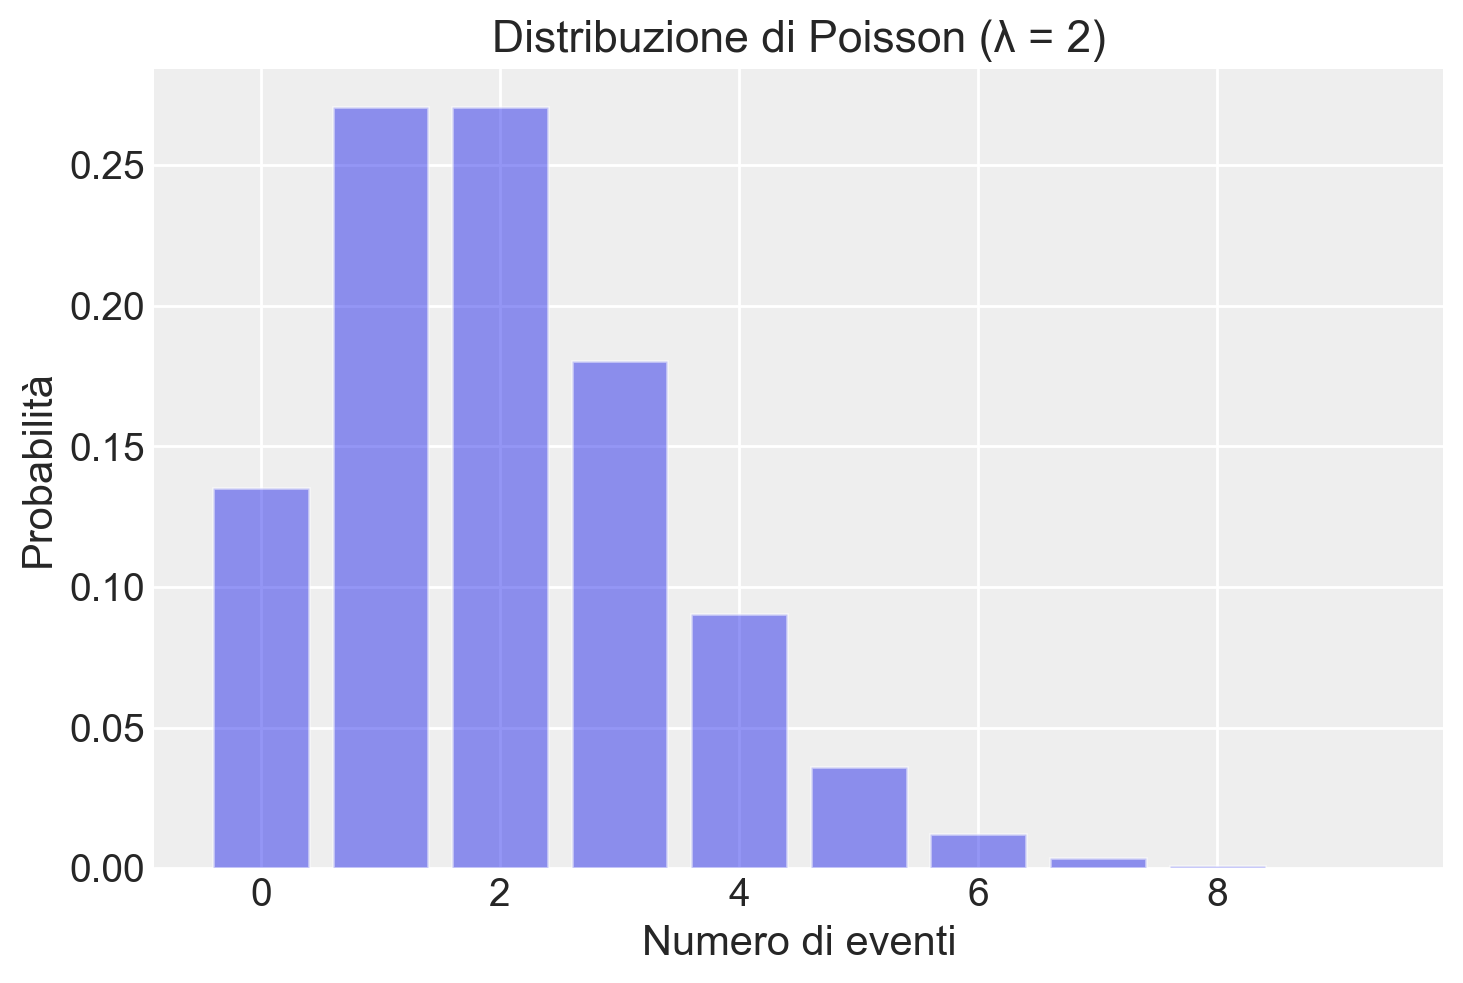

In [4]:
# Definiamo il parametro lambda
lambd = 2

# Generiamo i valori sull'asse x (numero di eventi)
x = np.arange(0, 10)  # Possiamo aumentare o diminuire il range a seconda delle esigenze

# Calcoliamo le probabilità corrispondenti utilizzando la funzione pmf di scipy.stats.poisson
y = stats.poisson.pmf(x, lambd)

# Creiamo il grafico a barre
plt.bar(x, y, alpha=0.5)

# Aggiungiamo le etichette agli assi
plt.xlabel('Numero di eventi')
plt.ylabel('Probabilità')
plt.title('Distribuzione di Poisson (λ = 2)')
plt.show()

## Verosimiglianza per un Campione di Osservazioni Poisson

Consideriamo un campione di $n$ osservazioni indipendenti e identicamente distribuite, $y_1, y_2, ..., y_n$, provenienti da una distribuzione di Poisson con parametro $\lambda$. La funzione di verosimiglianza $f(y \mid \lambda)$ rappresenta la probabilità congiunta di osservare esattamente questi valori dato un particolare valore di $\lambda$. 

Matematicamente, la verosimiglianza si esprime come:

$$
f(y \mid \lambda)=\prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
=\frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^{n}y_i!}.
$$

La verosimiglianza ci fornisce una misura della probabilità di osservare l'intero campione di dati, dato un valore specifico di $\lambda$. Più alta è la verosimiglianza, più compatibili sono i dati con il valore di $\lambda$ considerato. 

**Interpretazione intuitiva**

Consideriamo un campione di dati $y_1, y_2, ..., y_n$ e un parametro incognito $\lambda$. La funzione di verosimiglianza, associata a questo modello statistico, esprime la probabilità di osservare esattamente i dati campionati in funzione dei diversi valori possibili di $\lambda$. In altre parole, per ogni valore di $\lambda$, la funzione di verosimiglianza fornisce una misura di quanto quel valore sia plausibile alla luce dei dati osservati.

Spesso, per semplificare i calcoli e evitare problemi di overflow numerico, si lavora con il logaritmo naturale della funzione di verosimiglianza, chiamato log-verosimiglianza.

### Distribuzione Gamma

La distribuzione Gamma è fondamentale per il modello coniugato gamma-poisson, dove serve come distribuzione a priori per il parametro di tasso $\lambda$ di una distribuzione di Poisson. La sua scelta è motivata dalla sua coniugatezza con la Poisson, che semplifica i calcoli inferenziali.

La funzione di densità di probabilità della distribuzione Gamma è definita come:

$$ f(x \mid \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x}, $$

dove $\alpha$ controlla la forma della distribuzione (più alto è $\alpha$, più simmetrica è la distribuzione) e $\beta$ controlla la scala (più alto è $\beta$, più concentrata è la massa di probabilità vicino all'origine). Ad esempio, una distribuzione Gamma con $\alpha = 2$ e $\beta = 3$ rappresenta un processo in cui eventi relativamente rari si verificano occasionalmente, mentre una distribuzione con $\alpha = 10$ e $\beta = 1$ indica un processo più regolare con eventi frequenti.

::: {.callout-note}
In `Scipy`, la parametrizzazione è leggermente diversa. Il parametro di scala in `Scipy` è l'inverso del parametro $\beta$ nella formula sopra.
:::

Per calcolare la densità di probabilità in `scipy.stats`, si utilizza:

```python
stats.gamma.pdf(x, a=alpha, scale=1/beta)
```

Consideriamo il seguente esempio.

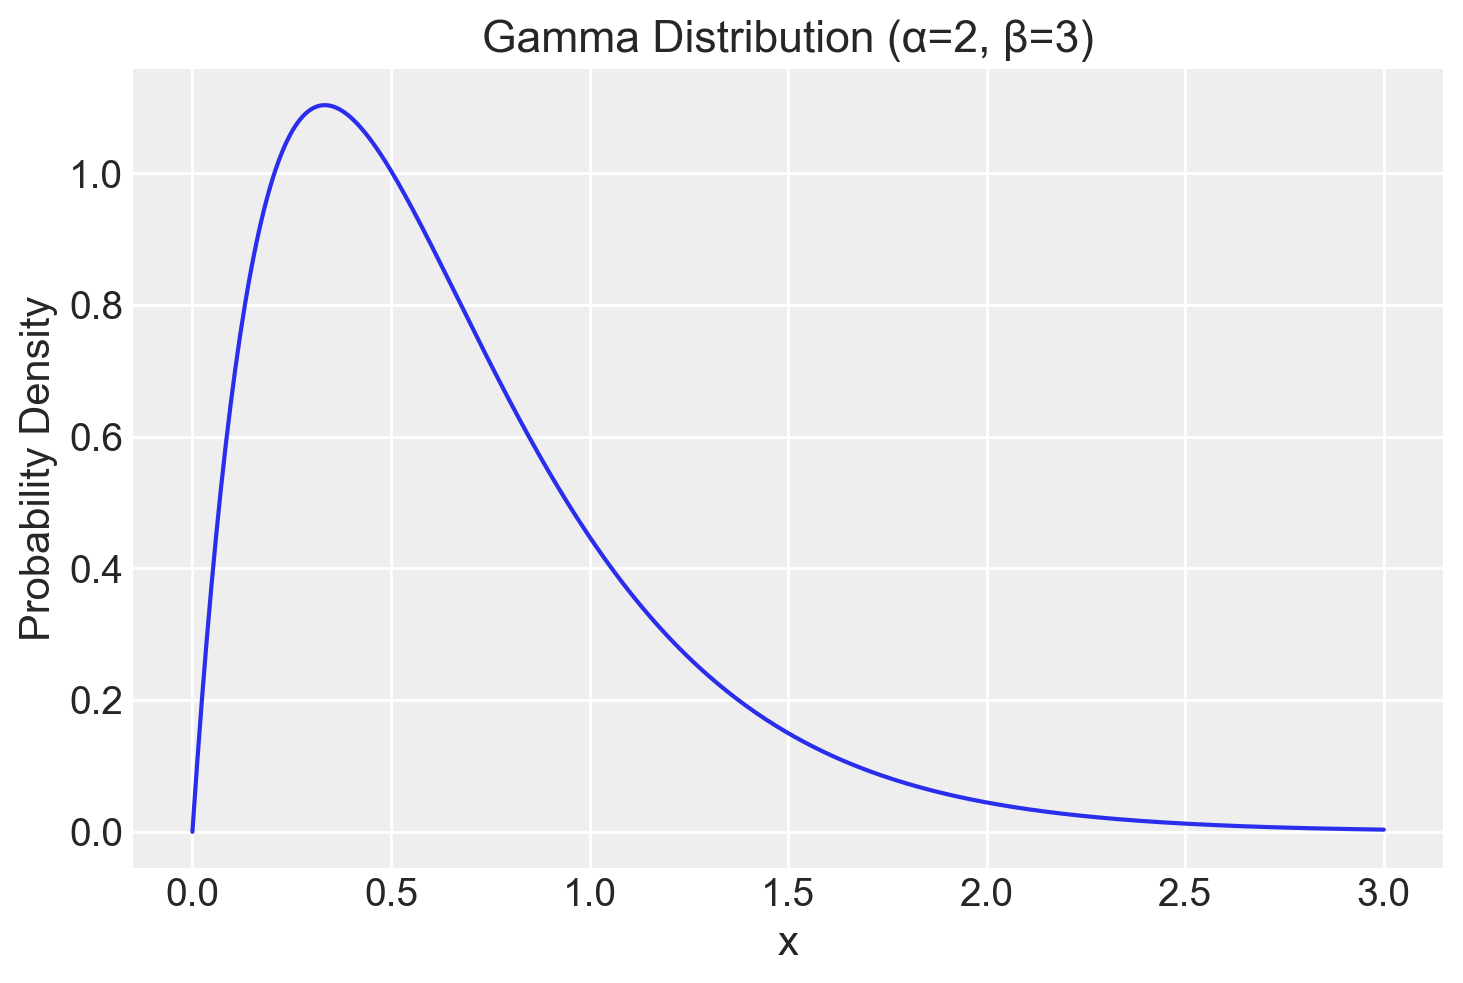

In [13]:
alpha = 2
beta = 3
x = np.linspace(0, 3, 500)
pdf = stats.gamma.pdf(x, a=alpha, scale=1/beta)
# Create plot
plt.plot(x, pdf)
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Gamma Distribution (α=2, β=3)")
plt.grid(True)
plt.show()

Il codice precedente calcola la densità di probabilità per una gamma con parametri $\alpha = 2$ e $\beta = 3$ su un intervallo da 0 a 3.

## Metodo Basato su Griglia

Poniamoci ora il problema di determinare la distribuzione a posteriori del parametro $\lambda$ di un modello di Poisson, adottando una distribuzione a priori Gamma. In questo primo esempio utilizzeremo un approccio numerico basato sulla discretizzazione dello spazio dei parametri (metodo della griglia). Supponiamo di avere osservato i seguenti dati.

In [49]:
y = np.array([2, 1, 3, 2, 2, 1, 1, 1])

Quale distribuzione a priori per il parametro $\lambda$ della distribuzione di Poisson, scegliamo una distribuzione Gamma con i seguenti parametri.

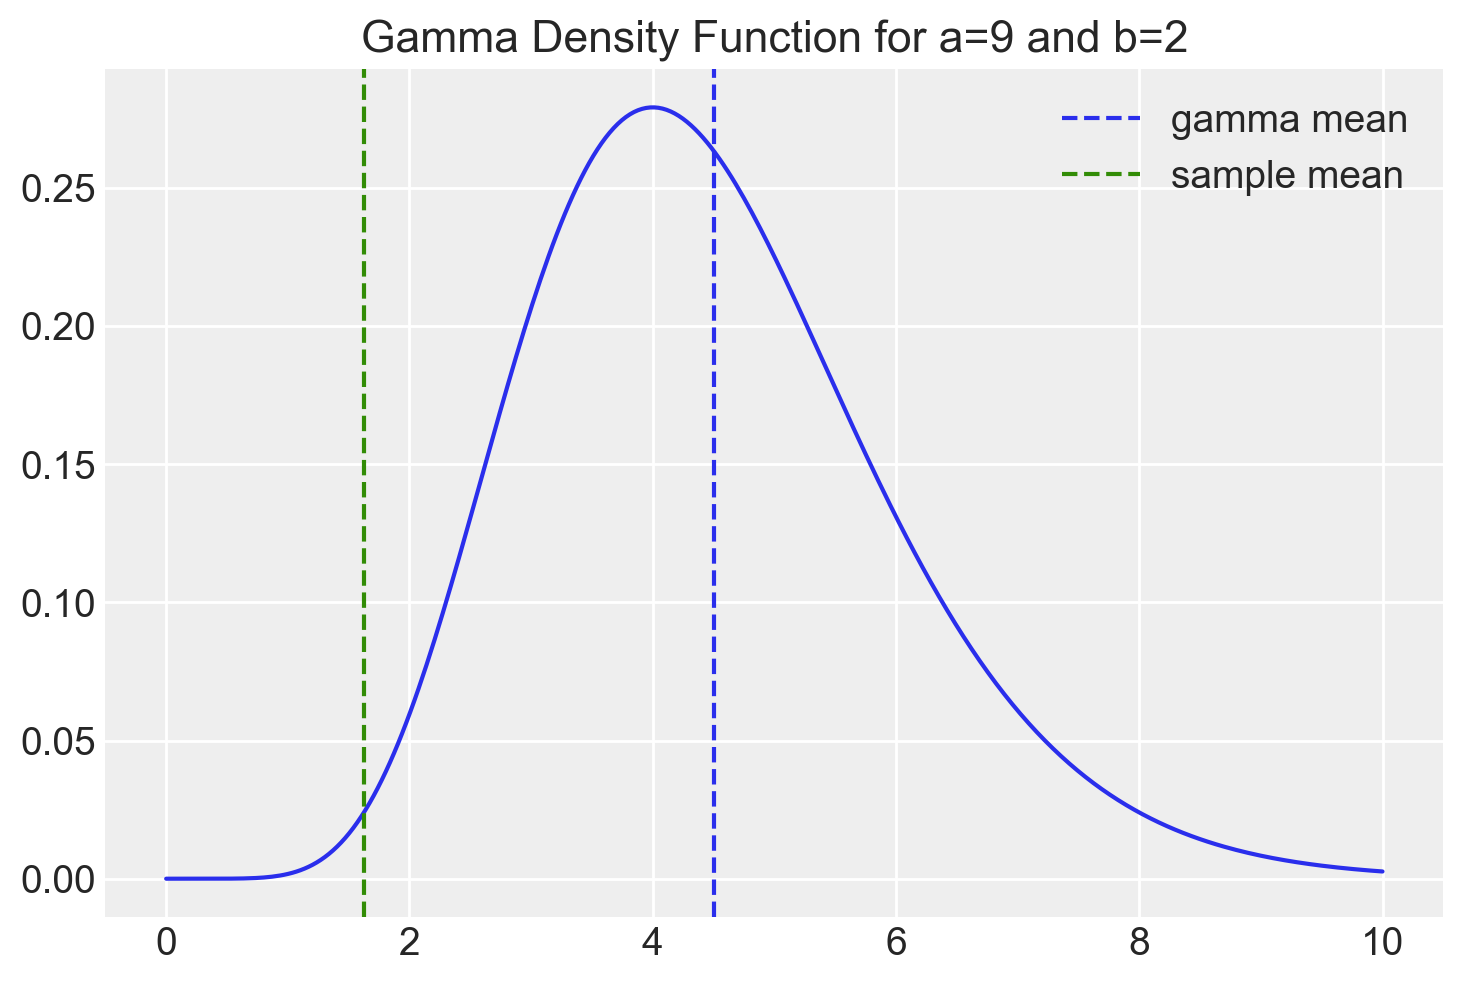

In [39]:
alpha_prior = 9
beta_prior = 2

x = np.linspace(start=0, stop=10, num=300)

plt.plot(x, stats.gamma.pdf(x, a=alpha_prior, scale=1 / beta_prior))
plt.axvline(x=alpha_prior / beta_prior, linestyle="--", label="gamma mean")
plt.axvline(x=y.mean(), linestyle="--", color="C2", label="sample mean")
plt.legend()
plt.title(f"Gamma Density Function for a={9} and b={2}")
plt.show()

Definiamo una griglia di valori per il parametro $\lambda$ nell'intervallo [0.01, 10].

In [14]:
# Omettiamo lo zero per evitare divisione per zero
lambda_grid = np.linspace(0.01, 10, 1000)
  
len(lambda_grid)

1000

Definiamo la nostra credenza iniziale sulla distribuzione del parametro $\lambda$ tramite una distribuzione Gamma. Assegniamo a ciascun possibile valore di $\lambda$ nella griglia un peso iniziale (la densità a priori) secondo una distribuzione Gamma con parametri `alpha_prior` e `beta_prior`. Questi pesi sono memorizzati nel vettore `prior`.

In [61]:
prior = stats.gamma.pdf(lambda_grid, a=alpha_prior, scale=1/beta_prior)
len(prior)

1000

Inizializziamo un vettore verosimiglianza con tutti gli elementi uguali a 1, della stessa lunghezza della griglia dei valori di $\lambda$. Successivamente, per ogni osservazione $y_i$ nei dati, calcoliamo la probabilità di massa di Poisson per ogni valore di $\lambda$ nella griglia e moltiplichiamo la verosimiglianza corrente per questo valore. Alla fine del ciclo, il vettore verosimiglianza conterrà la verosimiglianza totale per ogni valore di $\lambda$, dati i dati osservati.

In [62]:
likelihood = np.ones_like(lambda_grid)

for yi in y:
    likelihood *= stats.poisson.pmf(yi, lambda_grid)
    
len(likelihood)

1000

La verosimiglianza misura quanto bene un modello (in questo caso, una distribuzione di Poisson con un particolare valore di $\lambda$) spiega i dati osservati. Valori più alti della verosimiglianza indicano un migliore adattamento del modello ai dati. Utilizziamo il prodotto perché assumiamo che le osservazioni siano indipendenti. La probabilità congiunta di osservare tutti i dati è il prodotto delle probabilità individuali.

Secondo il teorema di Bayes, la distribuzione a posteriori è proporzionale al prodotto della verosimiglianza e della distribuzione a priori. Pertanto, calcoliamo la distribuzione a posteriori non normalizzata moltiplicando elemento per elemento la verosimiglianza per la distribuzione a priori. 

In [63]:
posterior_unnormalized = likelihood * prior

La moltiplicazione della verosimiglianza per la distribuzione a priori ha l'effetto di "pesare" i valori di $\lambda$ in base a quanto bene spiegano i dati e a quanto erano considerati plausibili a priori.

Calcoliamo il fattore di normalizzazione sommando i valori della distribuzione a posteriori non normalizzata, moltiplicati per la larghezza dell'intervallo della griglia (che rappresenta approssimativamente l'area di ciascun rettangolo nella stima dell'integrale). Dividendo la distribuzione non normalizzata per questo fattore, otteniamo una distribuzione di probabilità valida, ovvero una distribuzione che si integra a 1.

In [64]:
posterior = posterior_unnormalized / np.sum(
    posterior_unnormalized * (lambda_grid[1] - lambda_grid[0])
)

len(posterior)

1000

Il codice Python sotto riportato crea un grafico che visualizza sia la distribuzione a priori che quella a posteriori del parametro $\lambda$. 

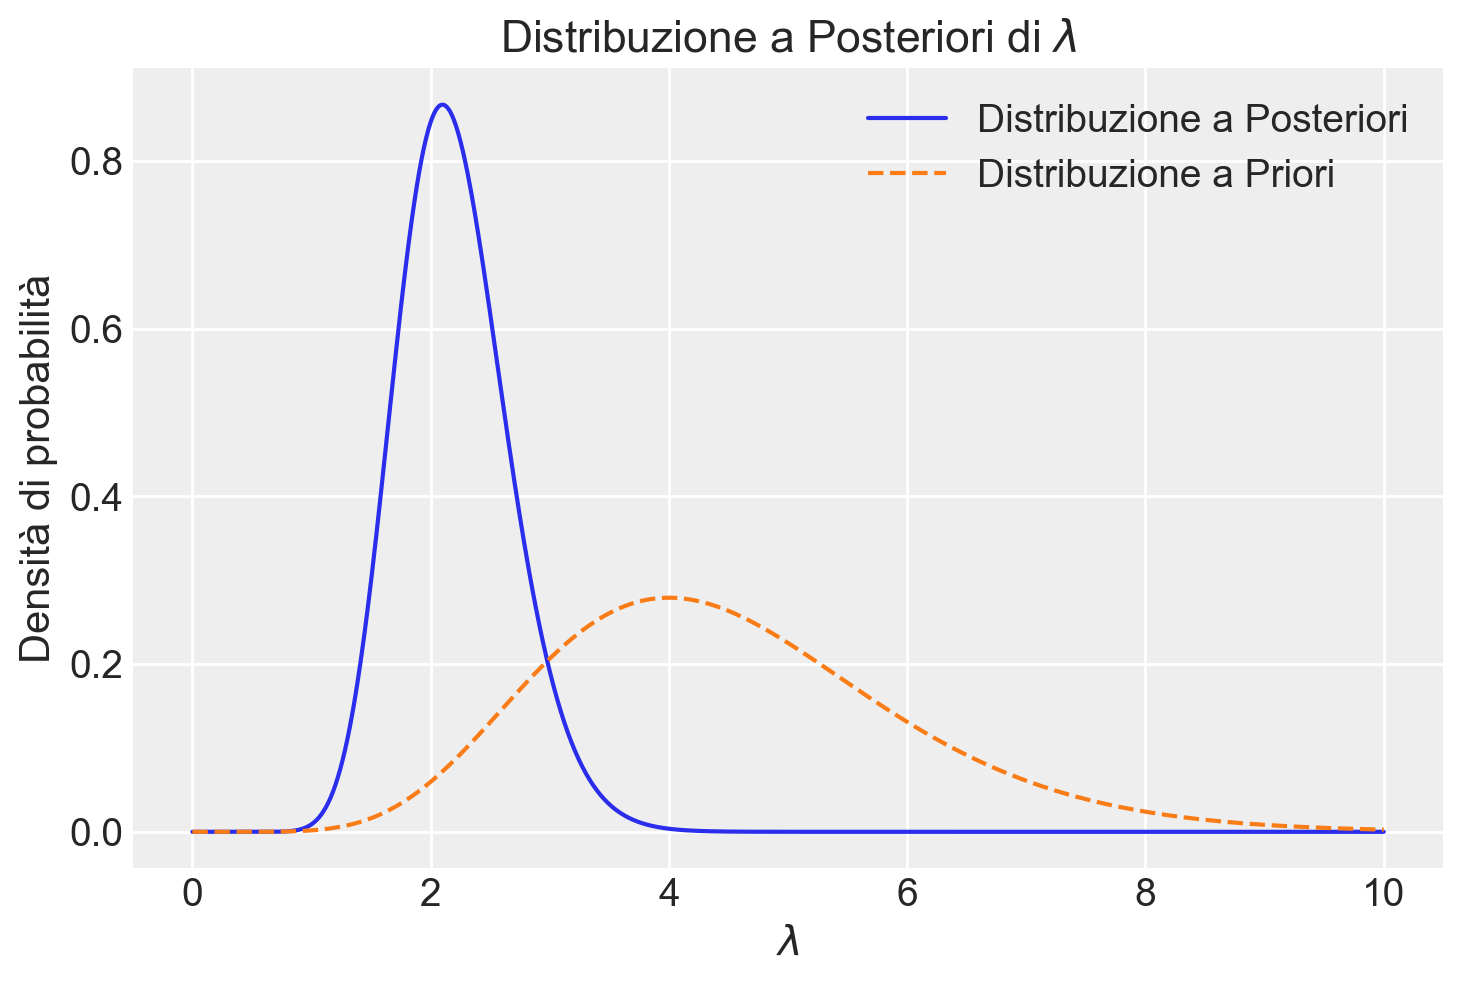

In [65]:
plt.plot(lambda_grid, posterior, label="Distribuzione a Posteriori")
plt.plot(lambda_grid, prior, "--", label="Distribuzione a Priori")
plt.xlabel(r"$\lambda$")
plt.ylabel("Densità di probabilità")
plt.legend()
plt.title("Distribuzione a Posteriori di $\lambda$")
plt.show()

Il grafico mostra come la nostra conoscenza sulla distribuzione del parametro $\lambda$ si evolve da una distribuzione a priori (prima di osservare i dati) a una distribuzione a posteriori (dopo aver osservato i dati). L'area sotto la curva rappresenta la probabilità. Confrontare le due distribuzioni permette di valutare l'impatto dei dati sulla nostra inferenza.

Nel caso presente

- la distribuzione a posteriori è spostata a sinistra rispetto alla distribuzione a priori, indicando che i dati hanno fornito nuove informazioni sul valore più probabile di $\lambda$;
- la distribuzione a posteriori è più stretta rispetto alla distribuzione a priori, indicando che i dati hanno ridotto l'incertezza sul valore di $\lambda$.

## Modello Coniugato Gamma-Poission

Per calcolare analiticamente la distribuzione a posteriori nel contesto di un modello gamma-Poisson possiamo seguire un processo diretto. Il modello Gamma-Poisson è coniugato, il che significa che la distribuzione a posteriori sarà ancora una distribuzione Gamma. 

Seguendo il teorema di Bayes, possiamo scrivere la distribuzione a posteriori come:

   $f(\lambda \mid y) \propto f(y \mid \lambda) \cdot f(\lambda) ,$

dove $f(\lambda \mid y)$ è la distribuzione a posteriori, $f(y \mid \lambda)$ è la verosimiglianza e $f(\lambda)$ è la distribuzione a priori.

Definiamo la verosimiglianza (distribuzione di Poisson):

   $f(y \mid \lambda) = \prod_{i=1}^n \frac{e^{-\lambda}\lambda^{y_i}}{y_i!} = \frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^n y_i!}.$

Definiamo la distribuzione a priori (distribuzione Gamma):

   $f(\lambda) = \frac{b^a}{\Gamma(a)}\lambda^{a-1}e^{-b\lambda}.$

Ora, moltiplichiamo la verosimiglianza per la distribuzione a priori:

   $f(\lambda|y) \propto \frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^n y_i!} \cdot \frac{b^a}{\Gamma(a)}\lambda^{a-1}e^{-b\lambda}.$

Semplifichiamo, eliminando i termini costanti (che non dipendono da $\lambda$):

   $f(\lambda \mid y) \propto e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i} \cdot \lambda^{a-1}e^{-b\lambda}.$

Raggruppiamo i termini:

   $f(\lambda|y) \propto \lambda^{\sum_{i=1}^n y_i} \cdot \lambda^{a-1} \cdot e^{-n\lambda} \cdot e^{-b\lambda}.$

Semplifichiamo ulteriormente:

   $f(\lambda \mid y) \propto \lambda^{\sum_{i=1}^n y_i + a - 1} \cdot e^{-(n+b)\lambda}.$

Riconosciamo che questa è la forma di una distribuzione Gamma con nuovi parametri:

   $f(\lambda \mid y) \propto \lambda^{(\sum_{i=1}^n y_i + a) - 1} \cdot e^{-(n+b)\lambda}.$

Quindi, la distribuzione a posteriori è una Gamma con parametri:

- $\alpha_{post} = a + \sum_{i=1}^n y_i$,
- $\beta_{post} = b + n$,

dove:

- $a$ e $b$ sono i parametri della distribuzione Gamma a priori,
- $\sum_{i=1}^n y_i$ è la somma di tutte le osservazioni,
- $n$ è il numero di osservazioni.

Questa derivazione mostra come la distribuzione a posteriori mantiene la forma di una Gamma, ma con parametri aggiornati che incorporano l'informazione dai dati osservati.

Consideriamo nuovamente l'esempio precedente. Utilizzando i parametri aggiornati, rappresentiamo graficamente la distribuzione a posteriori.

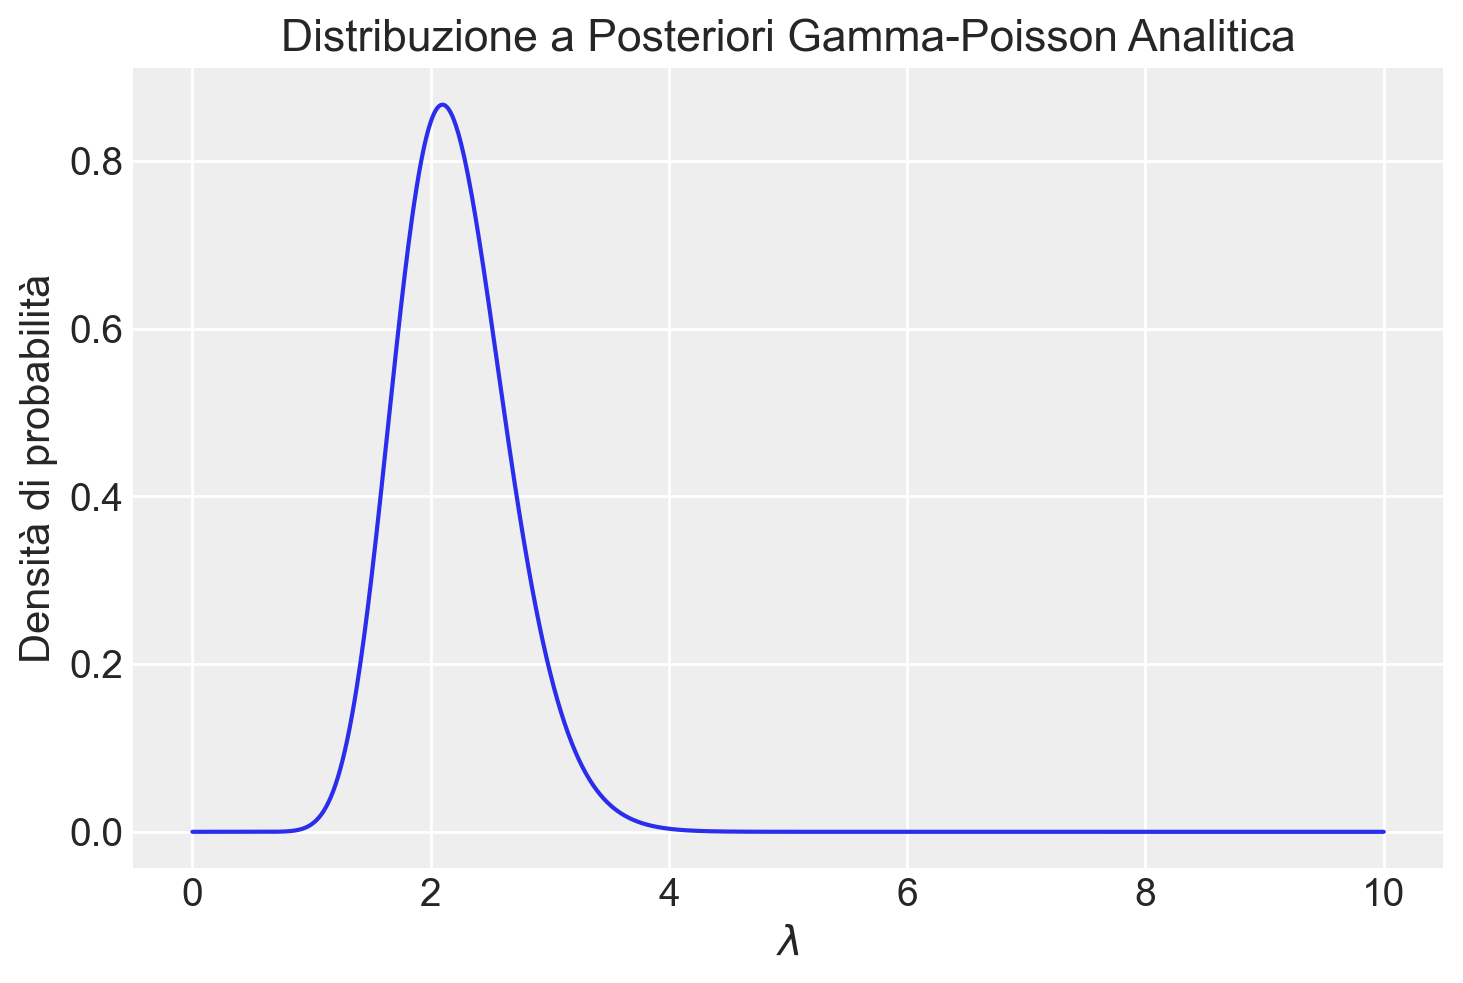

In [68]:
# Aggiornamento dei parametri per la distribuzione a posteriori
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + len(y)

# Calcolo della distribuzione a posteriori analitica sulla griglia
posterior_analytic = stats.gamma.pdf(lambda_grid, a=alpha_post, scale=1 / beta_post)

# Plot della distribuzione a posteriori analitica
plt.plot(lambda_grid, posterior_analytic)
plt.title("Distribuzione a Posteriori Gamma-Poisson Analitica")
plt.xlabel("$\lambda$")
plt.ylabel("Densità di probabilità")
plt.show()

Il grafico mostra la distribuzione a posteriori analitica del parametro di tasso $\lambda$ di un modello di Poisson, ottenuta utilizzando una distribuzione a priori Gamma e aggiornando i parametri alla luce dei dati osservati. La distribuzione a posteriori è calcolata come una Gamma aggiornata con i parametri $\alpha_{\text{post}}$ e $\beta_{\text{post}}$, e rappresenta la nostra conoscenza aggiornata dopo aver visto i dati. I risultati analitici concordano con quelli ottenuti tramite simulazione.

Procediamo ora con il calcolo della soluzione analitica per la media della distribuzione a posteriori del parametro $\lambda$.

In [69]:
# Posterior gamma parameters.
shape = alpha_prior + y.sum()
rate = beta_prior + y.size

# Posterior mean.
print(f"Posterior Mean = {shape / rate: 0.3f}")

Posterior Mean =  2.200


Sapendo che la distribuzione a posteriori è una Gamma di parametri 

In [72]:
print(f"shape = {shape: 0.1f}")
print(f"rate = {rate: 0.1f}")

shape =  22.0
rate =  10.0


possiamo calcolare la probabilità di qualsiasi evento di interesse. Per esempio, ci possiamo chiedere quale sia la probabilità di osservare più di 3 compulsioni per ora:

In [74]:
# Calcolo della probabilità che y > 3
prob_y_greater_than_3 = 1 - stats.gamma.cdf(3, a=shape, scale=1/rate)

print(
    f"La probabilità di osservare più di 3 compulsioni per ora è {prob_y_greater_than_3: 0.3f}"
)

La probabilità di osservare più di 3 complsioni per ora è  0.054


## Riflessioni Conclusive

Il modello Gamma-Poisson offre un framework robusto per l'inferenza bayesiana su dati di conteggio in psicologia. Partendo da una distribuzione a priori Gamma, che rappresenta la nostra conoscenza iniziale sul tasso medio, siamo in grado di aggiornare questa conoscenza alla luce dei dati osservati, ottenendo una distribuzione a posteriori che riflette in modo più preciso la realtà sottostante. Questo approccio permette di quantificare l'incertezza associata alle nostre stime e di prendere decisioni informate sulla base dei dati disponibili.

## Esercizi

::: {#exr-gamma-poisson-1}

Consideriamo uno studio longitudinale su coppie, dove i partecipanti registrano quotidianamente la frequenza con cui nascondono il loro comportamento di fumo al partner. Basandoci sui dati di @scholz2021people, assumiamo che il tasso medio di nascondere il fumo sia di 1.52 volte al giorno. Supponiamo di avere i seguenti dati giornalieri per un partecipante:

- Giorno 1: 2 volte.
- Giorno 2: 0 volte.
- Giorno 3: 1 volta.
- Giorno 4: 3 volte.

Utilizzare un modello Gamma-Poisson per stimare la distribuzione a posteriori del tasso individuale di nascondere il fumo per un partecipante specifico, dato il suo insieme di osservazioni giornaliere.

:::

## Informazioni sull'Ambiente di Sviluppo

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 02 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
pymc      : 5.15.0
scipy     : 1.13.0
arviz     : 0.18.0
matplotlib: 3.8.4
pandas    : 2.2.2

Watermark: 2.4.3

